# Preamble

In [1]:
HomeDir = '/Users/kvantilburg/Dropbox/projects/LuminousBasin/LuminousBasin/luminous-basin/'
DataDir = HomeDir+'mocks/event_lists/'
SourceDir = HomeDir+'data/likelihood_yellin_data/products_80610202001_orbit1_chu12_spatialARF/'
ProductionDir = HomeDir+'data/production/'
FigDir = HomeDir+'figs/'
import sys
sys.path.insert(0, HomeDir)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from preamble import *

from myUnits import *

from LuminousBasinFunctions import *

from Likelihood_Functions import *

In [2]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})
#rc('text', usetex=True)

# Parameters

In [3]:
i_mock = '6' #this controls which mock data set is loaded

In [4]:
width_E = 0.040
bins_E = np.arange(1.6,200.01,width_E)
sigma_E = 0.166
n_sigma_E = 1

In [5]:
alpha0=170.66855149
delta0=4.02092024

# Load Mock Data

## Load photons

In [6]:
list_files = listdir(DataDir); 
list_files = [file for file in list_files if file[0:len(i_mock)+1]==i_mock+'_'] #select only files starting with 'nu'
list_files

['6_B.csv', '6_A.csv']

In [7]:
RA = []; Dec = []; E = []; t = [];
for file in list_files:
    print(file)
    table = pd.read_csv(DataDir+file)
    RA = np.append(RA, table[' RA (deg)'])
    Dec = np.append(Dec, table[' Dec (deg)'])
    E = np.append(E, table[' Energy (keV)'])
    t = np.append(t, table['# Time (s)'])

6_B.csv
6_A.csv


## Define source region

In [8]:
df_box = load_box(SourceDir+'box_centers.txt')
df_box

,detector,i1,i2,ra,dec,delta_x,delta_y,rotation
0,A,0,0,170.926,3.89641,1.000',1.000',330
1,A,1,0,170.940,3.90475,1.000',1.000',330
2,A,-1,0,170.911,3.88808,1.000',1.000',330
3,A,2,0,170.955,3.91308,1.000',1.000',330
4,A,-2,0,170.897,3.87975,1.000',1.000',330
...,...,...,...,...,...,...,...,...
333,B,6,5,170.984,4.01517,1.000',1.000',330
334,B,-6,-6,170.902,3.75640,1.000',1.000',330
335,B,6,-6,171.076,3.85640,1.000',1.000',330
336,B,-6,6,170.802,3.92960,1.000',1.000',330


In [9]:
list_file_arf = [SourceDir+'arfs/'+file for file in listdir(SourceDir+'arfs/')]
df_arf = load_arf(list_file_arf,bins_E,df_box)
df_arf

339it [00:34,  9.94it/s]


,detector,idx_E,i1,i2,ra,dec,arf
0,B,0,6,1,171.017,3.95743,0.414818
1,B,0,6,1,171.017,3.95743,0.573579
2,B,2,6,1,171.017,3.95743,0.790342
3,B,3,6,1,171.017,3.95743,1.085458
4,B,3,6,1,171.017,3.95743,1.464541
...,...,...,...,...,...,...,...
1384443,A,4091,3,3,170.944,3.96472,0.000000
1384444,A,4091,3,3,170.944,3.96472,0.000000
1384445,A,4093,3,3,170.944,3.96472,0.000000
1384446,A,4094,3,3,170.944,3.96472,0.000000


In [10]:
good_time_ints = np.asarray([
    [3.37603341e+08, 3.376033795e+08],
    [3.376036305e+08, 3.3760522972e+08]
])
exposure = ((good_time_ints[0,1]-good_time_ints[0,0]) + (good_time_ints[1,1]-good_time_ints[1,0])) * Second;
exposure/Second

1637.7200000286105

## Plots

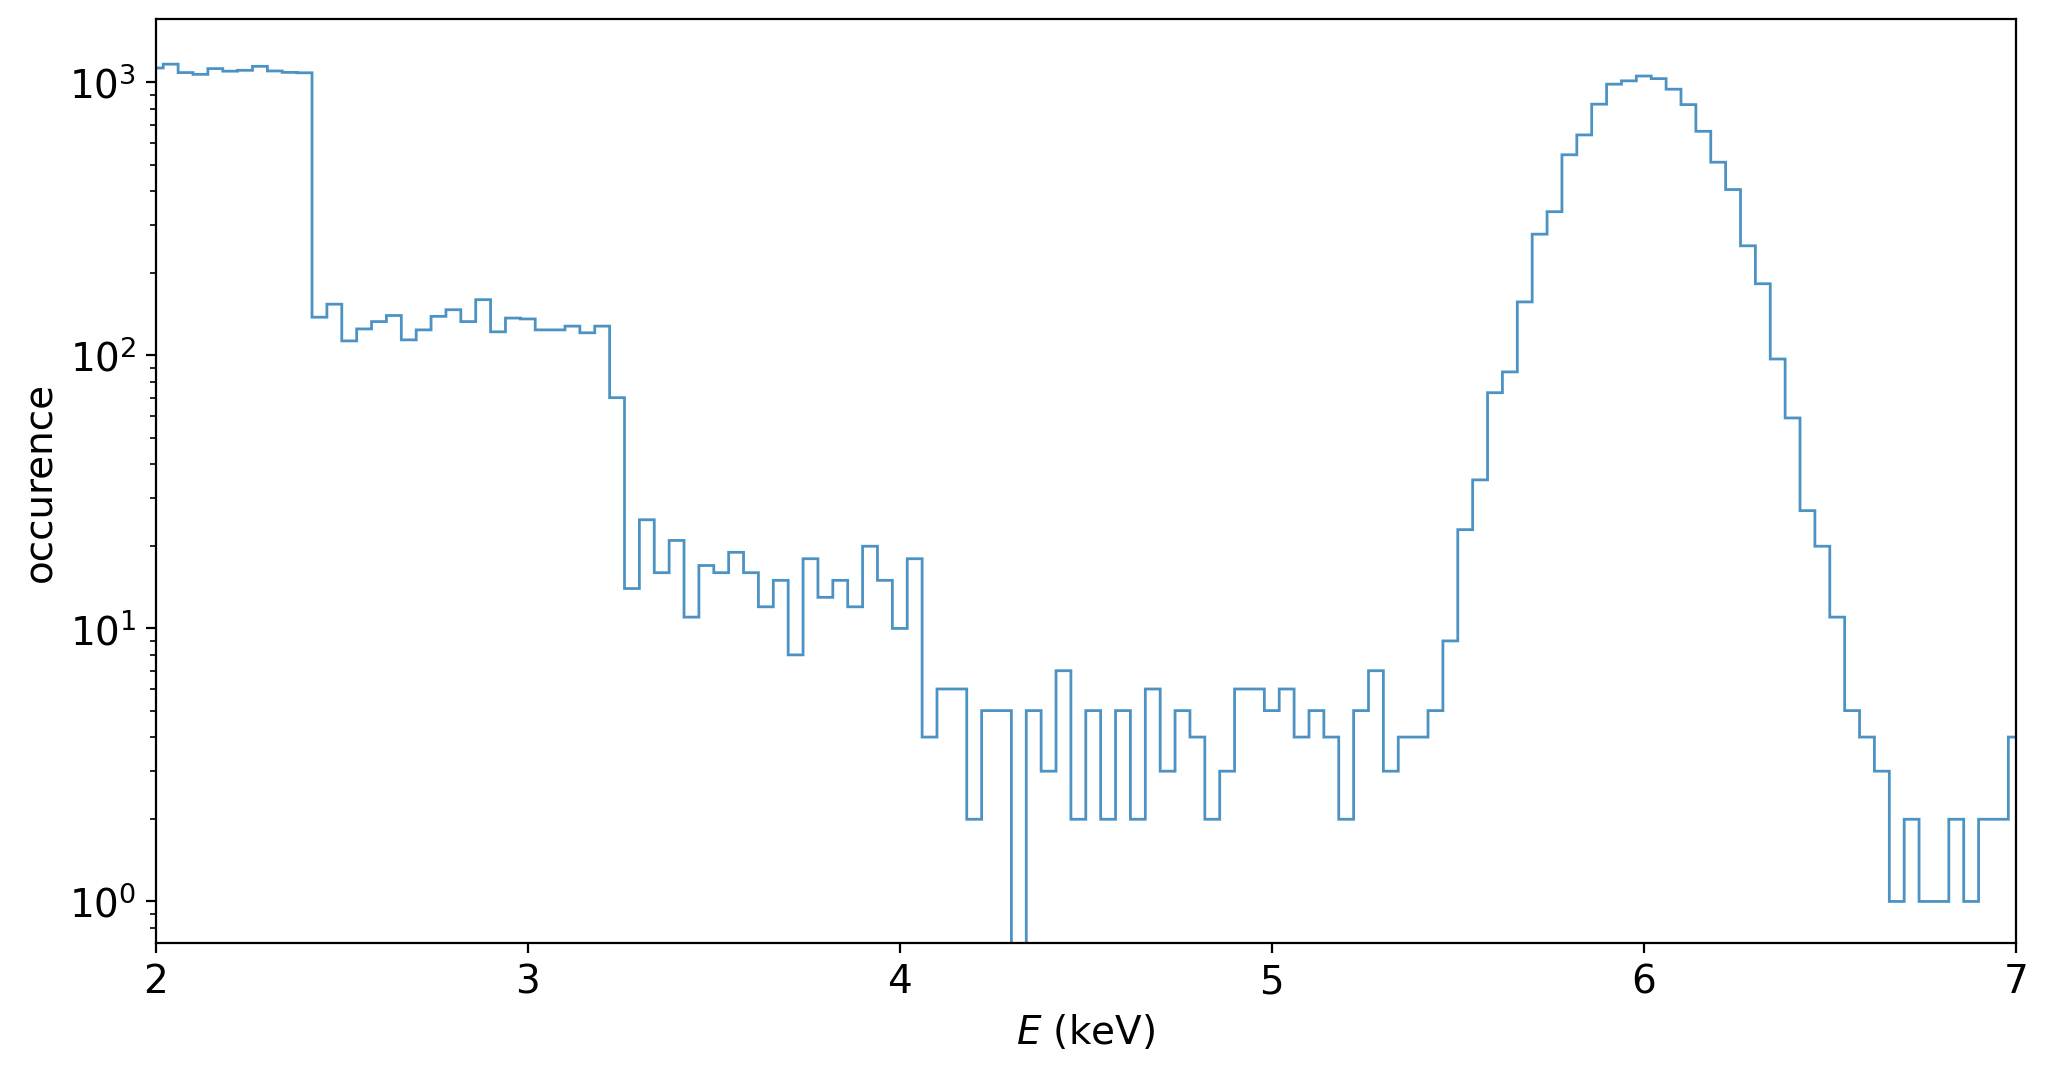

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
[hist_E,E_edges,image] = ax.hist(E,bins=np.arange(0.02,30.0,0.04),log=True,histtype='step',alpha=0.8);
ax.set_xlim(2,7); ax.set_xlabel('$E$ (keV)'); ax.set_ylabel('occurence');

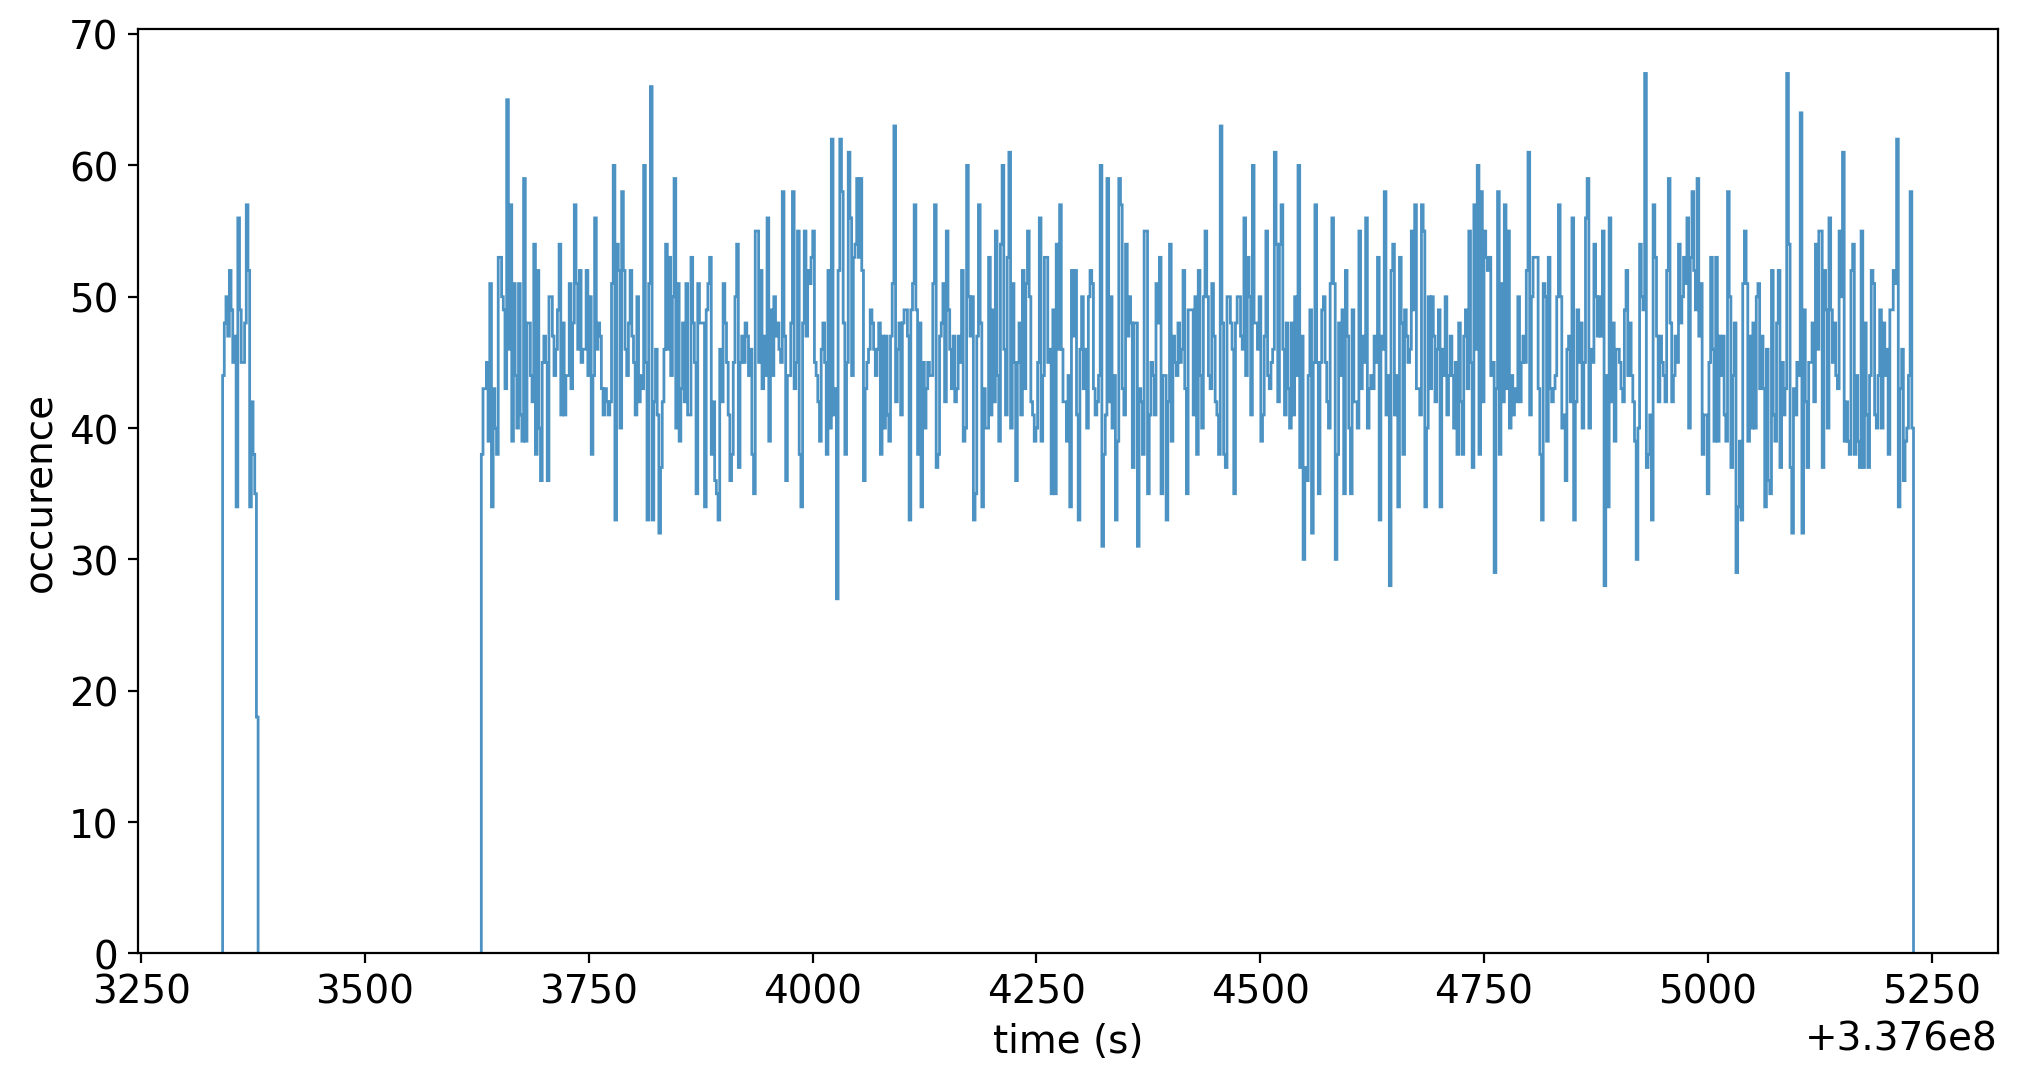

In [12]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
[hist_t,t_edges,image] = ax.hist(t,bins=1000,log=False,histtype='step',alpha=0.8);
ax.set_ylim(0,); #ax.set_xlim(0,12); 
ax.set_xlabel('time (s)'); ax.set_ylabel('occurence');

# Signal Calculation

## Intrinsic signal density

### Angular dependence

$\theta_\mathrm{sun}$ is the angular radius of the Sun at 1 AU

In [13]:
theta_sun = np.arcsin(RSolar/AU); print('theta_sun =',theta_sun/arcsec,'arcsec')

theta_sun = 956.3983296221267 arcsec


$z_\mathrm{min} = \sqrt{\sin^2 \theta_\mathrm{sun}  - \sin^2 \theta }$

In [14]:
def z_min(theta):
    """z_min function (returns zero if theta > theta_sun)"""
    theta = np.asarray(theta)
    vec_theta_sun = np.ones(theta.shape) * theta_sun
    vec_arg = np.minimum(theta,vec_theta_sun)
    return np.sqrt(np.sin(theta_sun)**2 - np.sin(vec_arg)**2)

flux template function: $$T(\theta) = \begin{cases} \frac{3\pi}{2} \sin^3 \theta_\mathrm{sun} \csc^3 \theta & \sin \theta  > \sin \theta_\mathrm{sun} \\ 
\frac{3}{4} \sin^3 \theta_\mathrm{sun} \csc^2\theta \left\lbrace \frac{4 z_\mathrm{min}}{-1 - 2 z_\mathrm{min}^2 + \cos 2 \theta } + [\pi - 2 \arctan(z_\mathrm{min} \csc \theta) \csc(\theta) ]\right\rbrace & \sin \theta \le \sin \theta_\mathrm{sun} \end{cases} $$

In [15]:
def T_flux_template(theta):
    theta = np.asarray(theta+1e-20); #(shift up to avoid dividing by zero)
    y = np.zeros(theta.shape)
    y += (theta > theta_sun) * 3 * np.pi / 2 * np.sin(theta_sun)**3 * np.sin(theta)**-3
    #curly_bracket = (4 * z_min(theta) / (-1 - 2*z_min(theta)**2+np.cos(2*theta)) + (np.pi - 2 * np.arctan(z_min(theta) * np.sin(theta)**-1) * np.sin(theta)**-1))
    y += (theta <= theta_sun) * 3 / 4 * np.sin(theta_sun)**3 * np.sin(theta)**-2 * (4 * z_min(theta) / (-1 - 2*z_min(theta)**2 + np.cos(2*theta)) + (np.pi - 2 * np.arctan(z_min(theta) * np.sin(theta)**-1)) * np.sin(theta)**-1)
    #y += (theta < theta_sun) * 3 / 4 * np.sin(theta_sun)**3 * np.sin(theta)**-2 * 
    return y

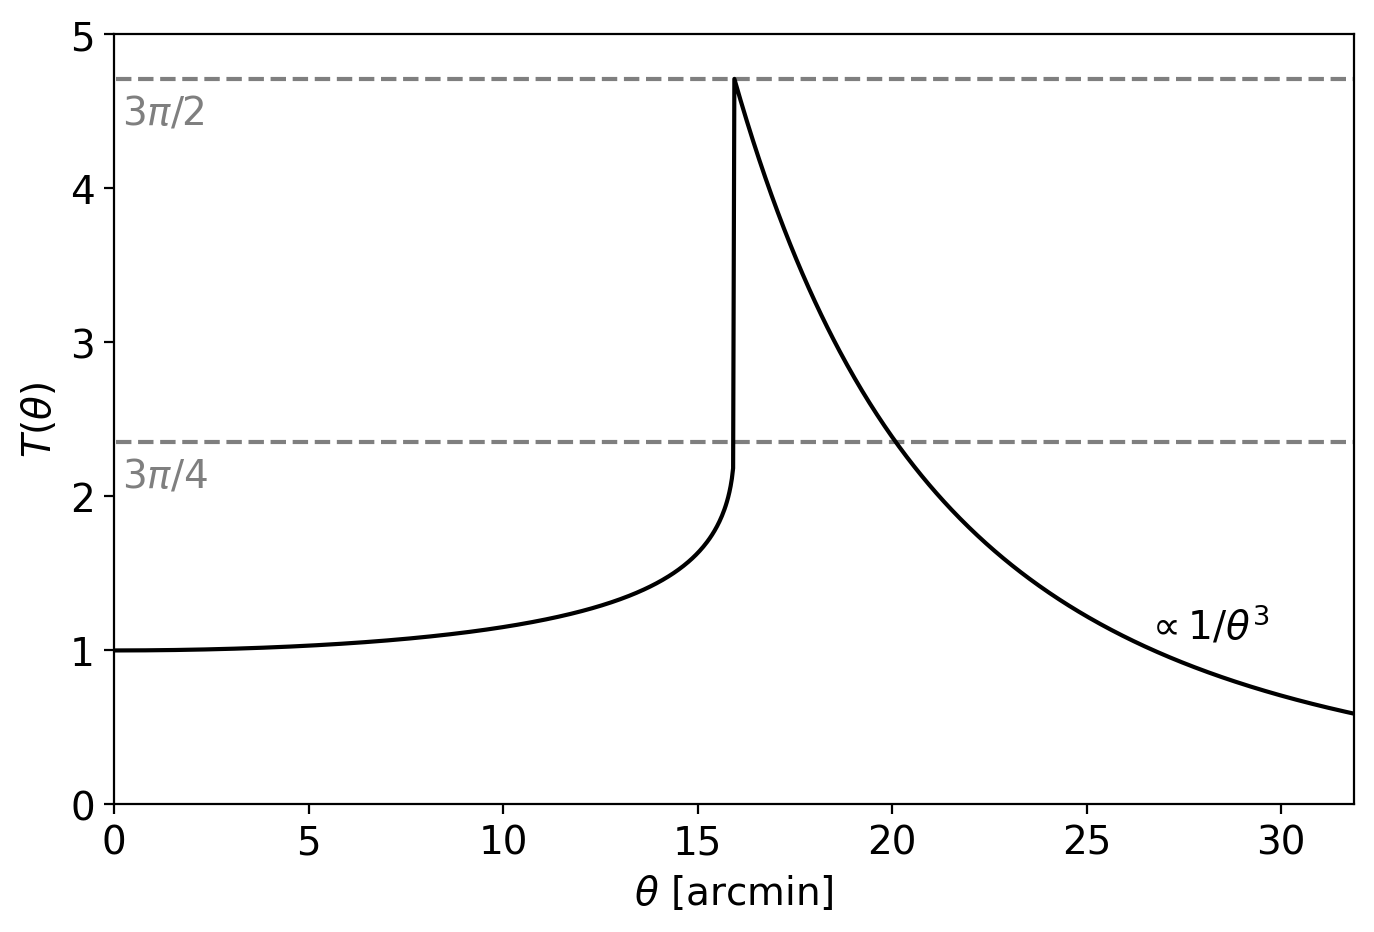

In [16]:
fig_template,ax = plt.subplots(1,1,figsize=(8,5))
vec_theta = np.linspace(1e-5,2*theta_sun,np.int(1e3))
ax.plot(vec_theta/arcmin, T_flux_template(vec_theta),color='black')
ax.set_ylim(0,5); ax.set_xlim(0,2*theta_sun/arcmin);
ax.set_xlabel(r'$\theta$ [arcmin]'); ax.set_ylabel(r'$T(\theta)$');
#ax.hlines(T_flux_template(theta_sun-1e-10),xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
#ax.hlines(T_flux_template(theta_sun+1e-10),xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.hlines(3*np.pi/2,xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.hlines(3*np.pi/4,xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.text(0.2,3*np.pi/2-0.1,r'$3 \pi / 2$',color=(0,0,0,0.5),ha='left',va='top');
ax.text(0.2,3*np.pi/4-0.1,r'$3 \pi / 4$',color=(0,0,0,0.5),ha='left',va='top');
ax.text(26.5,T_flux_template(26.5*arcmin),r'$\propto 1/\theta^3$',color=(0,0,0,1),ha='left',va='bottom');

### Axion decay rate

In [17]:
def Gamma_rad(m,gagg,gaee):
    """Decay rate in units of second^-1. Units: Gamma_rad, m [keV], gagg [GeV^-1]."""
    return (gagg)**2 * m**3 / (64 * np.pi) + AlphaEM**2 * gaee**2 / (9216 * np.pi**3) * m**7 / MElectron**6

In [18]:
tau_SS = 4.6e9 * Year

In [19]:
Gamma_rad(10*keV,1e-12*GeV**-1,1e-13) * tau_SS

1.0962969597021375

In [20]:
Gamma_rad(10*keV,1e-12*GeV**-1,0) / (1e9*Year)**-1

0.23832542597202253

In [21]:
Gamma_rad(10*keV,0,1e-13) / (1e9*Year)**-1

5.018126502901845e-11

### Injection rate

table of $\left \lbrace m\, [\mathrm{keV}], \, \frac{\dot{\rho}[\mathrm{AU}]}{m} \, [\mathrm{cm^{-3} \, s^{-1}}] \right\rbrace$ at $g_{aee} = 10^{-13}$

tables of $\left \lbrace m\, [\mathrm{keV}], \, \dot{\rho}[\mathrm{R_\odot}] \, [\mathrm{GeV \, cm^{-3} \, yr^{-1}}] \right\rbrace$ at $g_{ae} = 1$, $g_{a\gamma} = 1\, \mathrm{GeV^{-1}}$, respectively

In [22]:
tab_e = np.asarray(pd.read_csv(ProductionDir+'tabe.csv'))
tab_gamma = np.asarray(pd.read_csv(ProductionDir+'tabgamma.csv'))

In [23]:
int_rho_dot_over_m_e = interp1d(np.log10(tab_e[:,0]),np.log10(tab_e[:,1]/tab_e[:,0] * (GeV/keV) * (RSolar/AU)**4),
                                bounds_error=False,fill_value=(1e-100,1e-100))
int_rho_dot_over_m_gamma = interp1d(np.log10(tab_gamma[:,0]),np.log10(tab_gamma[:,1]/tab_gamma[:,0] * (GeV/keV) * (RSolar/AU)**4),
                                bounds_error=False,fill_value=(1e-100,1e-100))

In [24]:
def fn_rho_dot_over_m(m, gaee, gagg):
    """Returns number density injection rate at R = 1 AU.
    Units: m [keV], gagg [GeV^-1]"""
    return (CentiMeter**-3 * Year**-1) * (gaee**2 * 10**int_rho_dot_over_m_e(np.log10(m/keV)) + (gagg * GeV)**2 * 10**int_rho_dot_over_m_gamma(np.log10(m/keV)))

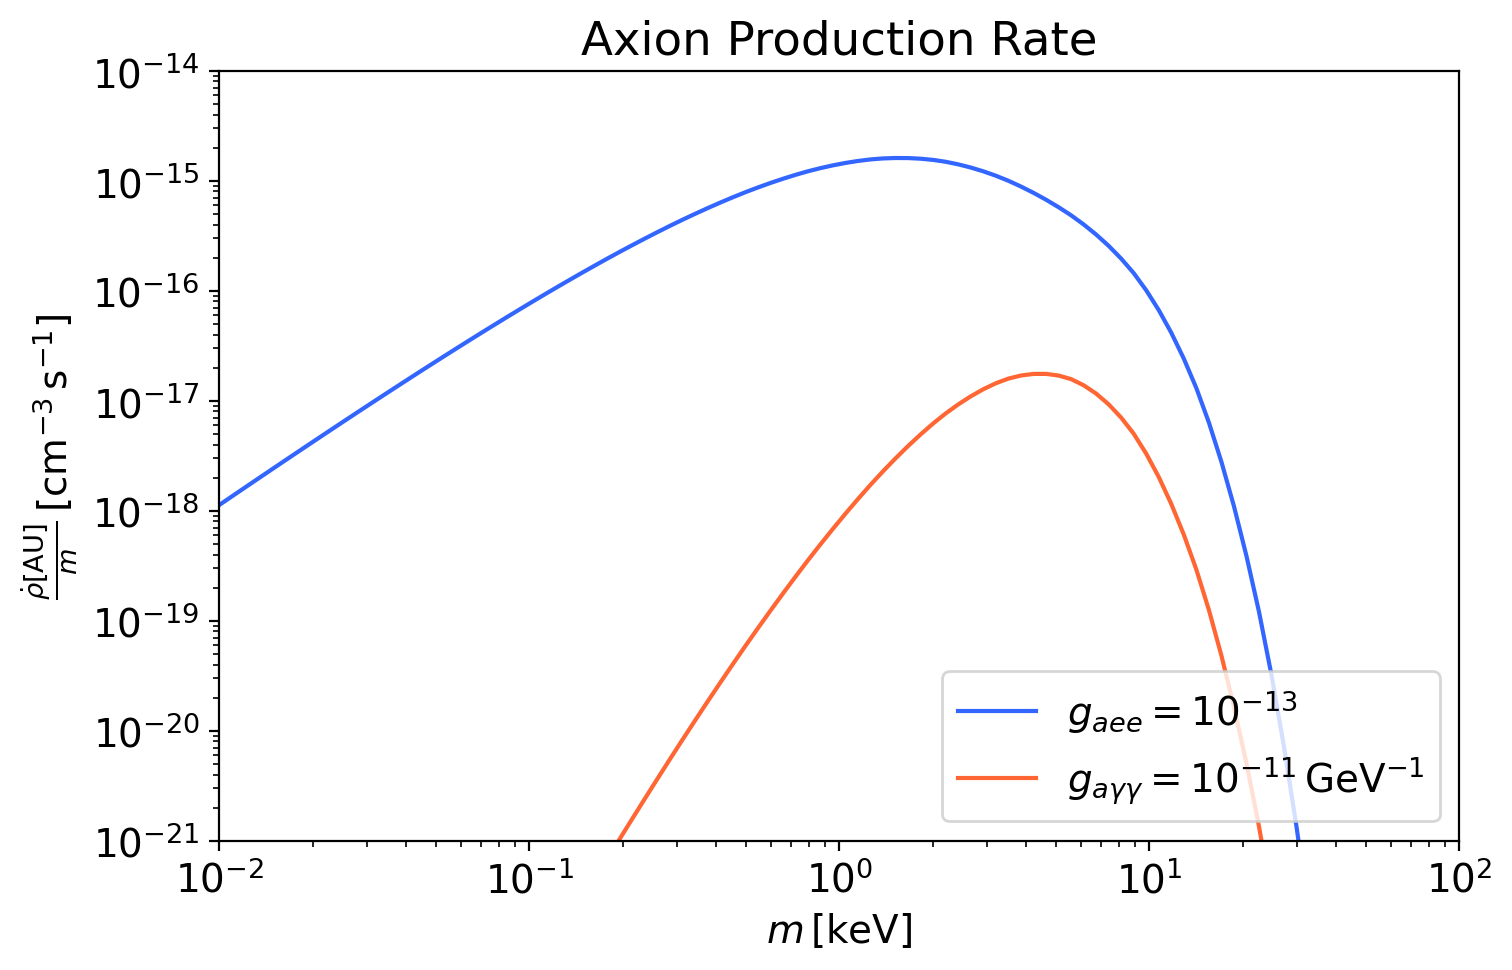

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 1e-13, 0)/(CentiMeter**-3 * Second**-1),color = (0.2,0.4,1), label=r'$g_{aee} = 10^{-13}$');
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 0, 1e-11*GeV**-1)/(CentiMeter**-3 * Second**-1), color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.01,100);
ax.set_ylim(1e-21,1e-14);
ax.set_ylabel(r'$\frac{\dot{\rho}[\mathrm{AU}]}{m} \, [\mathrm{cm^{-3} \, s^{-1}}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion Production Rate'); ax.legend();

### Total signal

$$
F(\theta, \phi, E) =  B_0[m] e^{-(E-m/2)/T_0[m]} + \frac{1}{\sqrt{2\pi \sigma_E^2}}\exp\left\lbrace{-\frac{(E-m/2)^2}{2\sigma_E^2}}\right\rbrace S[m] T(\theta)
$$

In [26]:
def K_signal(m,gaee,gagg):
    """Signal count rate per unit area and per solid angle on the celestial sphere, in the center of the Sun (theta = 0). 
    Units: m [keV], gagg [GeV^-1]"""
    factor_prod = fn_rho_dot_over_m(m,gaee,gagg) / (6*np.pi) * AU**4 * RSolar**-3
    factor_decay = (1 - np.exp(-Gamma_rad(m,gagg,gaee) * tau_SS))
    return factor_prod * factor_decay

In [27]:
K_signal(10 * keV,1e-13,1e-12*GeV**-1) / Meter**-2 / Second**-1 * arcsec**2

0.00011515641509807726

\begin{align}
K[m,g_{aee},g_{agg}] &= \frac{\dot\rho_\mathrm{b}[\mathrm{AU}]}{6\pi m} \frac{\mathrm{AU}^4}{R_\odot^3} \left(1 - e^{-\Gamma_\mathrm{rad} \tau_\mathrm{SS}} \right)  \\
\frac{\mathrm{d} N}{\mathrm{d}t \, \mathrm{d}E \, \mathrm{d} \Omega} &= A \epsilon[t,E=m/2,\theta,\phi] \frac{1}{\sqrt{2\pi \sigma_E^2}}\exp\left\lbrace{-\frac{(E-m/2)^2}{2\sigma_E^2}}\right\rbrace K[m,g_{aee},g_{agg}] T(\theta)
\end{align}

In [28]:
10**6 * GeV * CentiMeter**-3 * (1e9 * Year)**-1 * RSolar / (6 * np.pi * (10 * keV)) / (Second**-1 * CentiMeter**-2 * arcsec**-2)

2.7500803457334065e-07

# Poisson Limit

## Total Expected Signal

$$ N_\mathrm{signal}[m,g_{aee},g_{agg}] = A K[m,g_{aee},g_{agg}] \int \mathrm{d}\Omega \, \mathrm{dt} \, \epsilon[t,E=m/2,\theta,\phi]  T(\theta)
$$

In [29]:
m = 20 * keV
df_arf_m = df_arf[np.abs(bins_E[df_arf['idx_E']]-(m/keV)/2) < n_sigma_E*sigma_E] # units = [cm^2]
df_arf_m

,detector,idx_E,i1,i2,ra,dec,arf
206,B,206,6,1,171.017,3.95743,124.867645
207,B,207,6,1,171.017,3.95743,124.335365
208,B,208,6,1,171.017,3.95743,123.832642
209,B,209,6,1,171.017,3.95743,123.409058
210,B,209,6,1,171.017,3.95743,121.644356
...,...,...,...,...,...,...,...
1380563,A,210,3,3,170.944,3.96472,240.999008
1380564,A,211,3,3,170.944,3.96472,235.211197
1380565,A,212,3,3,170.944,3.96472,229.411819
1380566,A,213,3,3,170.944,3.96472,223.596649


In [30]:
def integral_signal(m):
    df_arf_m = df_arf[np.abs(bins_E[df_arf['idx_E']]-(m/keV)/2) < n_sigma_E*sigma_E] 
    arf = df_arf_m['arf'] * CentiMeter**2
    Omega = 1 * arcmin**2
    theta = np.sqrt( (np.cos(df_arf_m['dec']*degree) * (df_arf_m['ra']-alpha0)*degree)**2 + ((df_arf_m['dec']-delta0)*degree)**2 )
    T_theta = T_flux_template(theta)
    E_weight = np.exp( - (bins_E[df_arf_m['idx_E']] - (m/keV)/2)**2 / (2*sigma_E**2) ) / np.sqrt(2*np.pi * sigma_E**2) * width_E
    integral = exposure * Omega * np.sum(arf * T_theta * E_weight)
    return integral

In [31]:
def N_signal(m,gaee,gagg,precompute=False,integral=None):
    if precompute==False:
        integral = integral_signal(m)
    else:
        pass
    return K_signal(m,gaee,gagg) * integral

In [32]:
N_signal(10*keV,1e-14,1e-11*GeV**-1)

374.8834230098403

In [33]:
integral = integral_signal(10*keV)

In [34]:
N_signal(10*keV,1e-14,1e-11*GeV**-1,precompute=True,integral=integral)

374.8834230098403

## Total Recorded Data

$$ N_\mathrm{data}[m] = \sum_i^{\mathrm{data}} \Theta\left[1 - \frac{|E_i-m/2|}{\sigma_E} \right] $$

In [35]:
def N_data(m,sigma_E=0.166*keV):
    tmp = 0
    prob = np.heaviside(1 - np.abs(E * keV - m/2)/sigma_E,0)
    return np.sum(prob)

In [36]:
N_data(10*keV)

37.0

## Comparitive Plot

In [37]:
gaee = 10**-14; 
gagg = 10**-12 * GeV**-1; 

<ipython-input-24-9487a938c43c>:4: RuntimeWarning: divide by zero encountered in log10
  return (CentiMeter**-3 * Year**-1) * (gaee**2 * 10**int_rho_dot_over_m_e(np.log10(m/keV)) + (gagg * GeV)**2 * 10**int_rho_dot_over_m_gamma(np.log10(m/keV)))


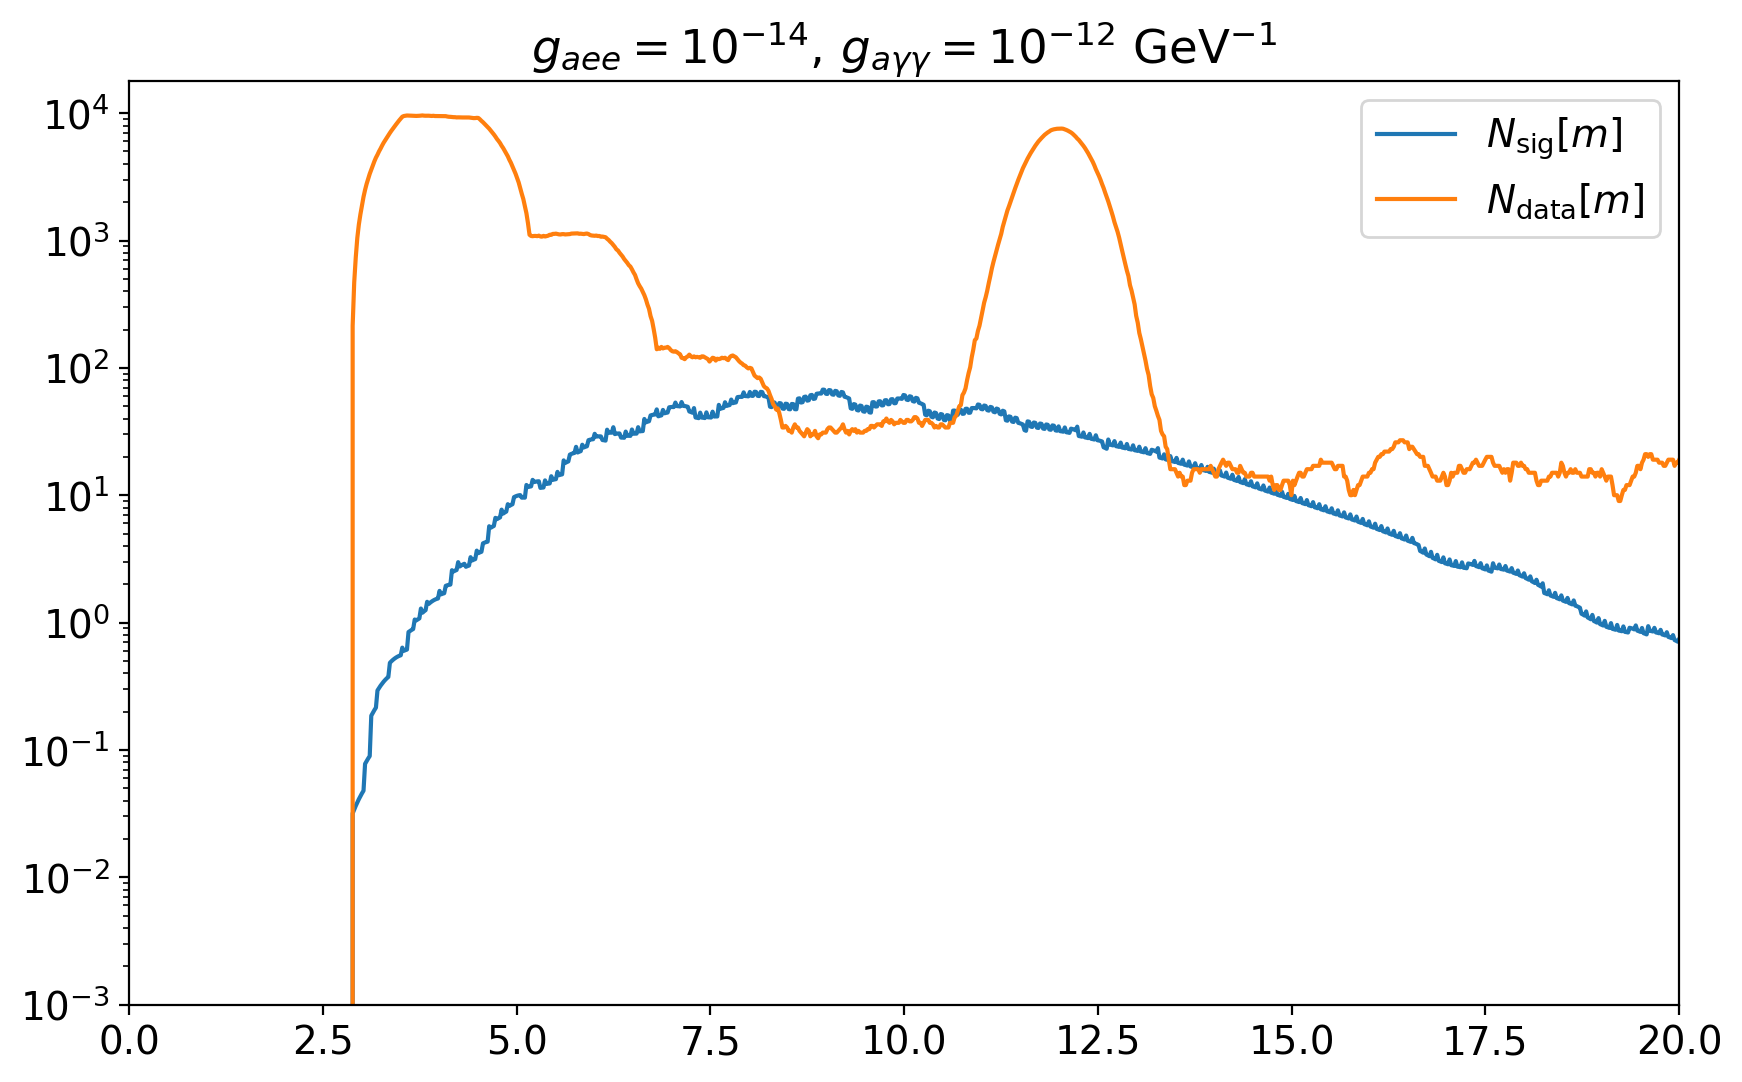

In [38]:
vec_m = np.linspace(0,20,1000) * keV
vec_sig = np.asarray([N_signal(m,gaee,gagg) for m in vec_m])
vec_data = np.asarray([N_data(m) for m in vec_m])

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(vec_m/keV,vec_sig,label='$N_\mathrm{sig}[m]$')
ax.plot(vec_m/keV,vec_data,label='$N_\mathrm{data}[m]$')
ax.set_yscale('log');
ax.set_ylim(1e-3,);ax.set_xlim(vec_m[0]/keV,vec_m[-1]/keV);
ax.set_title('$g_{aee} = 10^{-14}, \, g_{a\gamma\gamma} = 10^{-12}~\mathrm{GeV}^{-1}$')
ax.legend();

## Other Constraints

### Electron constraints

In [39]:
def lim_extrapolate(m,T):
    s = m/T;
    def integrand(x):
        if x < 100:
            return x**2 * (x**2 - s**2)**(1/2) / (np.exp(x)-1)
        else:
            return 0
    
    integral = quad(integrand,s,np.max([1e3,1e3*s]))[0]
    prefac = (np.pi**4/15)**-1
    return np.max([1e-100,np.sqrt(prefac * integral)])

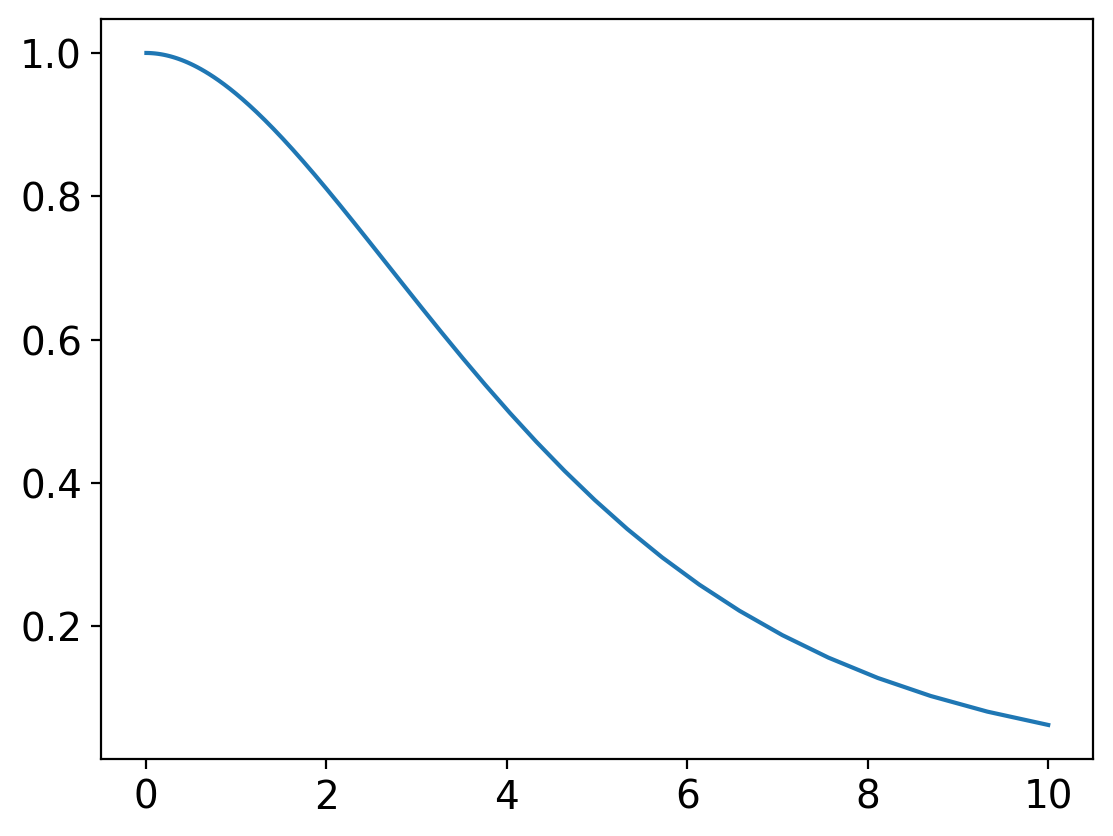

In [40]:
vec_m = np.logspace(-2,1,100)
plt.plot(vec_m,[lim_extrapolate(m,1) for m in vec_m])

In [41]:
def gaee_lim_WD(m,T=10**7 * Kelvin):
    lim_0 = 3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [42]:
def gaee_lim_RG(m,T=10**8 * Kelvin):
    lim_0 = 4.3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [43]:
lim_extrapolate(1e-2,1)

0.9999936725460565

### Photon constraints

In [44]:
def gagg_lim_HB(m,T=10**8 * Kelvin):
    lim_0 = 6.6 * 10**-11 * GeV**-1
    return lim_0 / lim_extrapolate(m,T)

In [45]:
gagg_lim_HB(1e-2*keV)/GeV**-1

6.600000564987312e-11

In [46]:
lim_extrapolate(60*keV,10**8 * Kelvin)

0.19276519610258389

## Limit

### Poisson function

In [47]:
def poisson_limit(N_dat,CL=0.9):
    N_sig = np.logspace(0,8,np.int(1e5))
    idx = np.argwhere(np.diff(np.sign((1-CL) - stats.poisson.cdf(N_dat,N_sig)))).flatten()[0]
    return N_sig[idx]

In [48]:
poisson_limit(0),poisson_limit(100)

(2.302309055277051, 114.06189206392084)

### Limit contours at fixed mass

In [49]:
from shapely import geometry

def findIntersection(contour1,contour2):
  p1 = contour1.collections[0].get_paths()[0]
  v1 = p1.vertices

  p2 = contour2.collections[0].get_paths()[0]
  v2 = p2.vertices

  poly1 = geometry.LineString(v1)
  poly2 = geometry.LineString(v2)

  intersection = poly1.intersection(poly2)

  return intersection

In [50]:
#list_m = keV * np.logspace(-1,2,np.int(1e2))
vec_m = keV * np.concatenate([np.arange(4.0,10,2),np.arange(10.,20,5.),np.arange(20.0,40.,10.)])
vec_gaee = np.logspace(-16,-11,np.int(2e2))
vec_gagg = GeV**-1 * np.logspace(-15,-8,np.int(3e2))
arr_N_signal = np.zeros((len(vec_m),len(vec_gaee),len(vec_gagg)))
for i_m, m in enumerate(tqdm(vec_m)):
    integral = integral_signal(m)
    for i_e, gaee in enumerate(vec_gaee):
        for i_g, gagg in enumerate(vec_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg,precompute=True,integral=integral)

100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


In [51]:
arr_N_data = np.zeros(len(vec_m));
arr_N_limit = np.zeros(len(vec_m));
for i_m, m in enumerate(vec_m):
    arr_N_data[i_m] = N_data(m)
    arr_N_limit[i_m] = poisson_limit(N_data(m))
arr_N_data, arr_N_limit

(array([9.477e+03, 1.092e+03, 9.900e+01, 3.700e+01, 1.000e+01, 1.900e+01, 8.000e+00]),
 array([9601.95847782, 1135.40434406,  112.99533931,   46.08256405,   15.40607036,   25.89966418,   12.99245248]))

In [52]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

In [53]:
arr_prod_ratio = np.zeros((len(vec_m),len(vec_gaee),len(vec_gagg)))
for i_m, m in enumerate(tqdm(vec_m)):
    for i_e, gaee in enumerate(vec_gaee):
        for i_g, gagg in enumerate(vec_gagg):
            arr_prod_ratio[i_m,i_e,i_g] = fn_rho_dot_over_m(m,0,gagg)/fn_rho_dot_over_m(m,gaee,0)

100%|██████████| 7/7 [00:27<00:00,  3.88s/it]


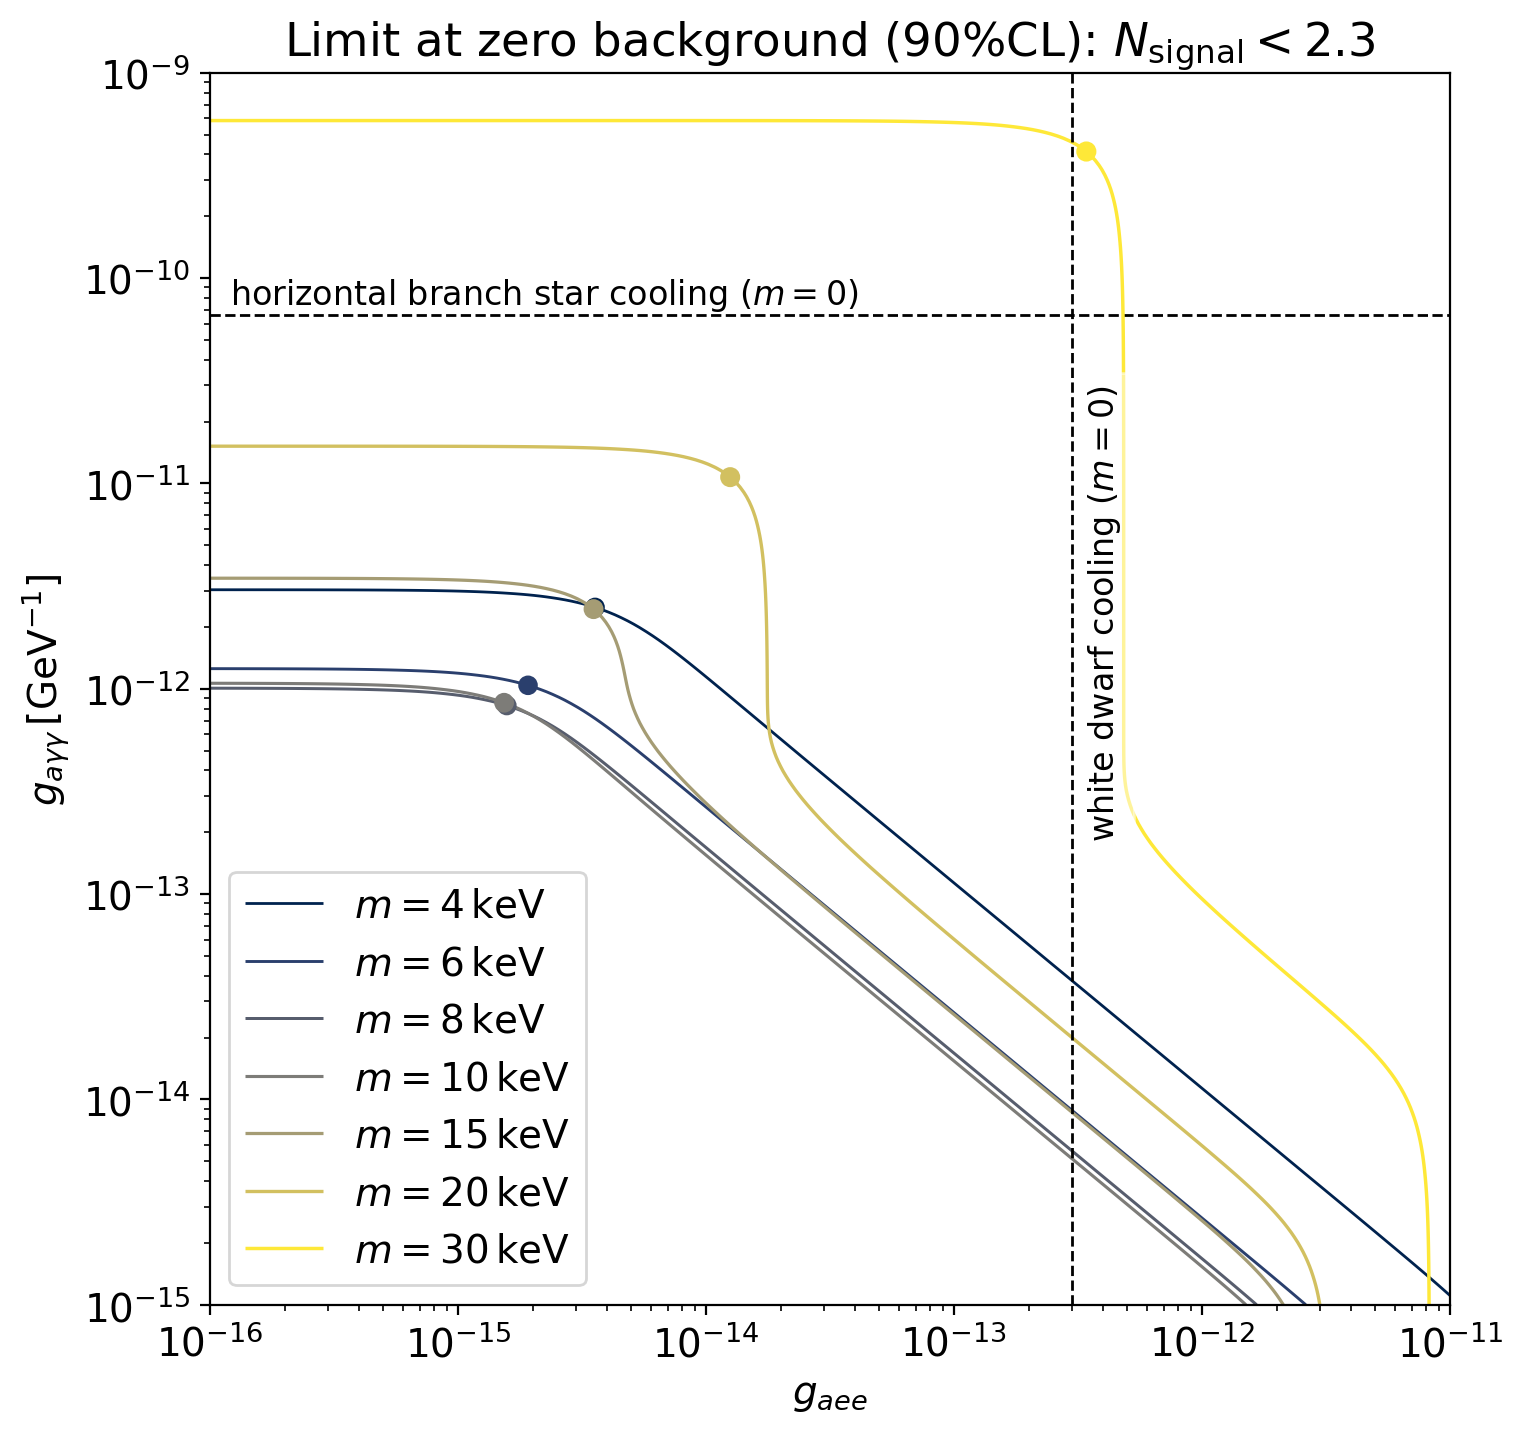

In [54]:
cmap = mpl.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(vec_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 4 \, \mathrm{keV}$','$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$','$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$',
           '$m = 30 \, \mathrm{keV}$','$m = 40 \, \mathrm{keV}$']
fig_lim1, ax = plt.subplots(1,1,figsize=(8,8))
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,vec_gaee[0],vec_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(vec_m),2))
for i_m, m in enumerate(vec_m):
    c1 = ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_N_signal[i_m])),levels=[np.log10(poisson_limit(0))],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_prod_ratio[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));

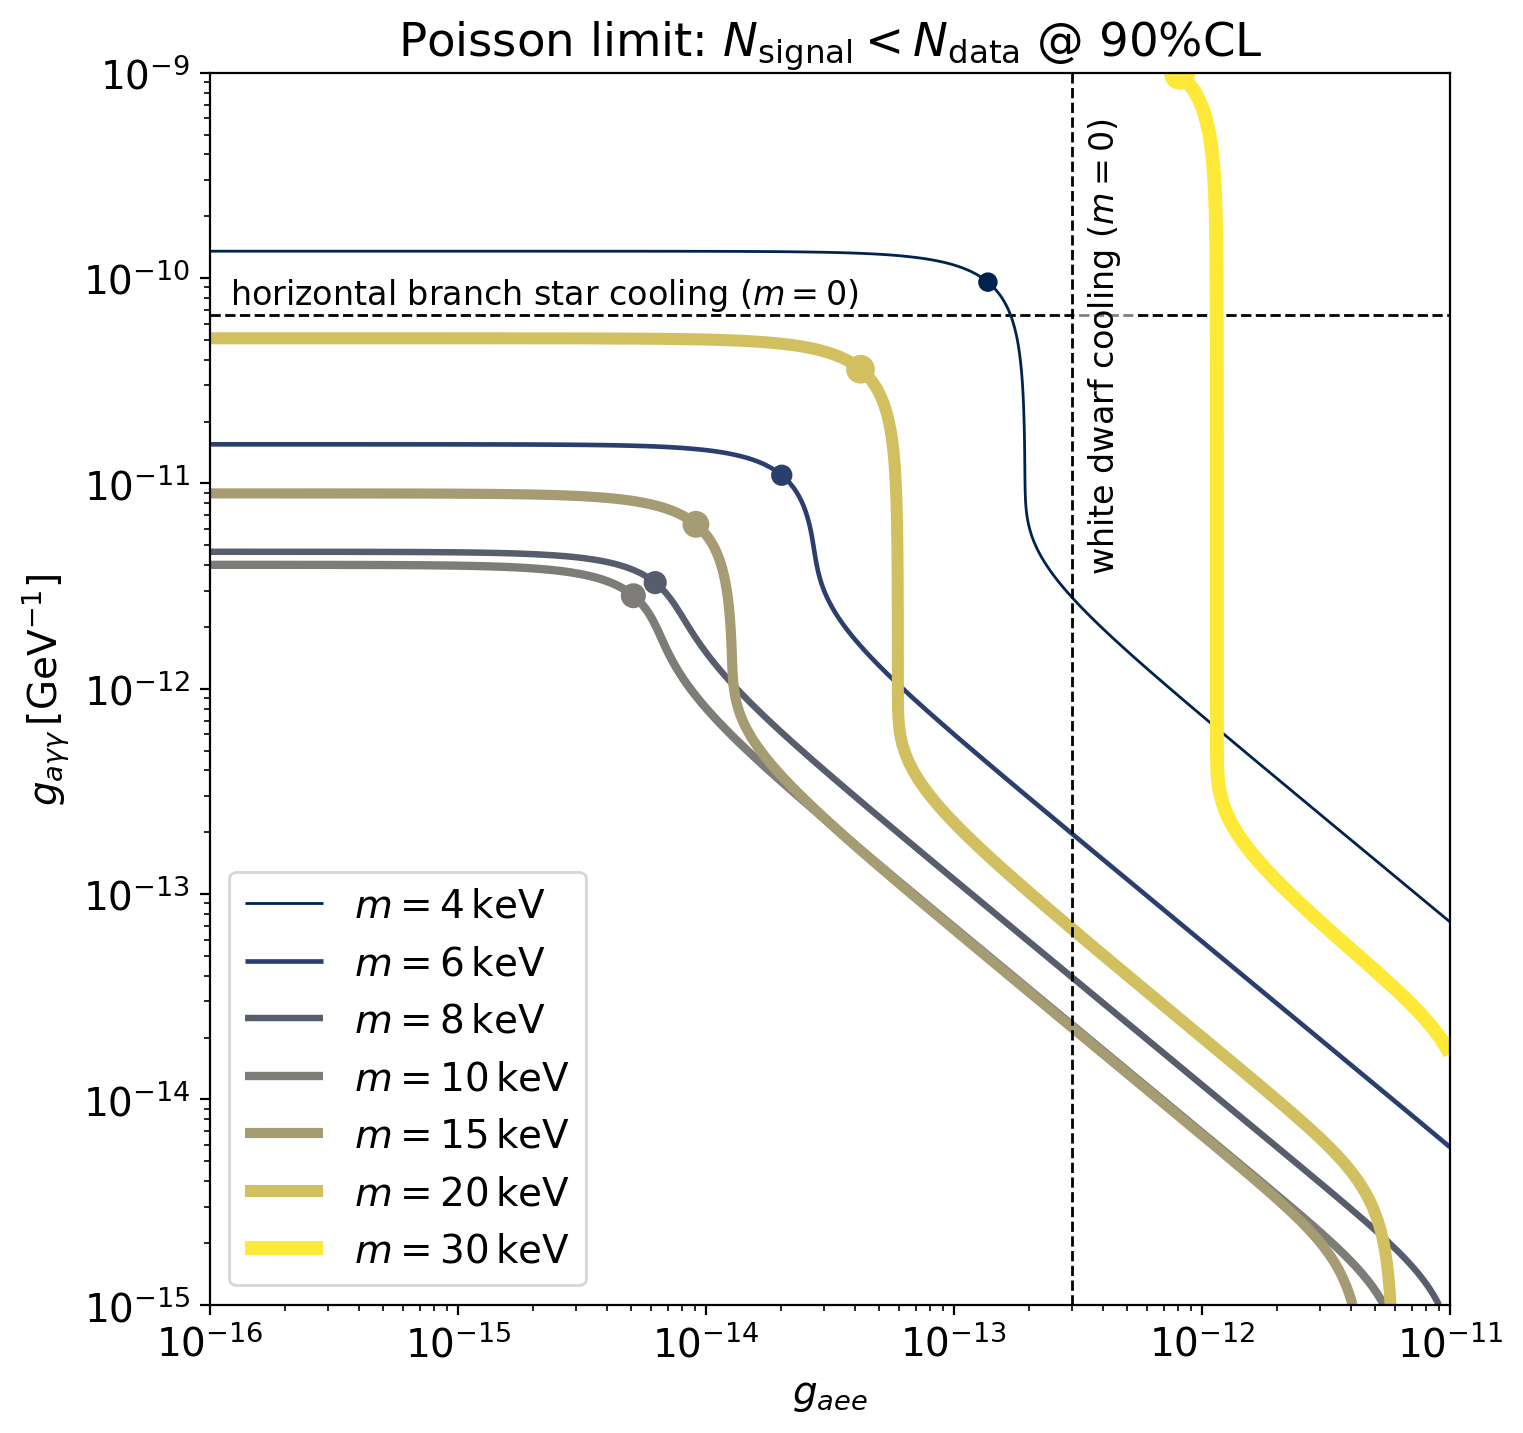

In [55]:
list_colors = cmap(np.linspace(0,1,len(vec_m)))
list_lw = np.linspace(1,5,len(vec_m))
labels = ['$m = 4 \, \mathrm{keV}$','$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$','$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$',
           '$m = 30 \, \mathrm{keV}$','$m = 40 \, \mathrm{keV}$']
fig_lim2, ax = plt.subplots(1,1,figsize=(8,8))
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,vec_gaee[0],vec_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)

arr_intersection = np.zeros((len(vec_m),2))
for i_m, m in enumerate(vec_m):
    c1 = ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_prod_ratio[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],
                    #colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.text(3.4e-13,4e-12,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));

### Pure Photon Coupling Limit

In [68]:
vec_m = keV * np.logspace(np.log10(2),np.log10(50),np.int(5e2))
vec_gaee = np.asarray([0,1e-14,1e-13,1e-12])
vec_gagg = GeV**-1 * np.logspace(-15,-9,np.int(3e2))
arr_N_signal = np.zeros((len(vec_m),len(vec_gaee),len(vec_gagg)))
for i_m, m in enumerate(tqdm(vec_m)):
    integral = integral_signal(m)
    for i_e, gaee in enumerate(vec_gaee):
        for i_g, gagg in enumerate(vec_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg,precompute=True,integral=integral)+1e-100

100%|██████████| 500/500 [00:30<00:00, 16.64it/s]


In [69]:
arr_N_data = np.zeros(len(vec_m));
arr_N_limit = np.zeros(len(vec_m));
for i_m, m in enumerate(vec_m):
    arr_N_data[i_m] = N_data(m)+1e-100
    arr_N_limit[i_m] = poisson_limit(N_data(m)+1e-100)
#arr_N_data, arr_N_limit

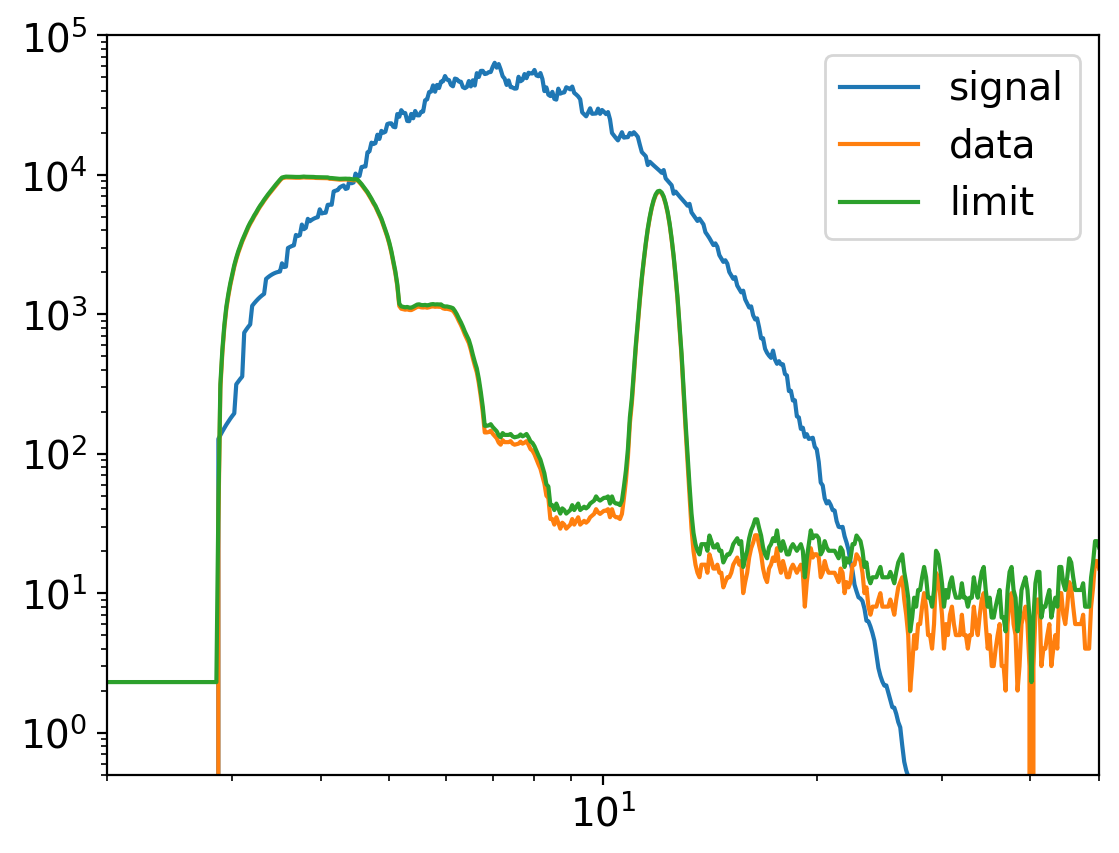

In [76]:
plt.plot(vec_m/keV,arr_N_signal[:,0,250],label='signal')
plt.plot(vec_m/keV,arr_N_data[:],label='data')
plt.plot(vec_m/keV,arr_N_limit[:],label='limit')
plt.xscale('log'); plt.yscale('log');
plt.xlim(2,50); plt.ylim(5e-1,1e5);
plt.legend();

In [77]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

(1e-10, 100000.0)

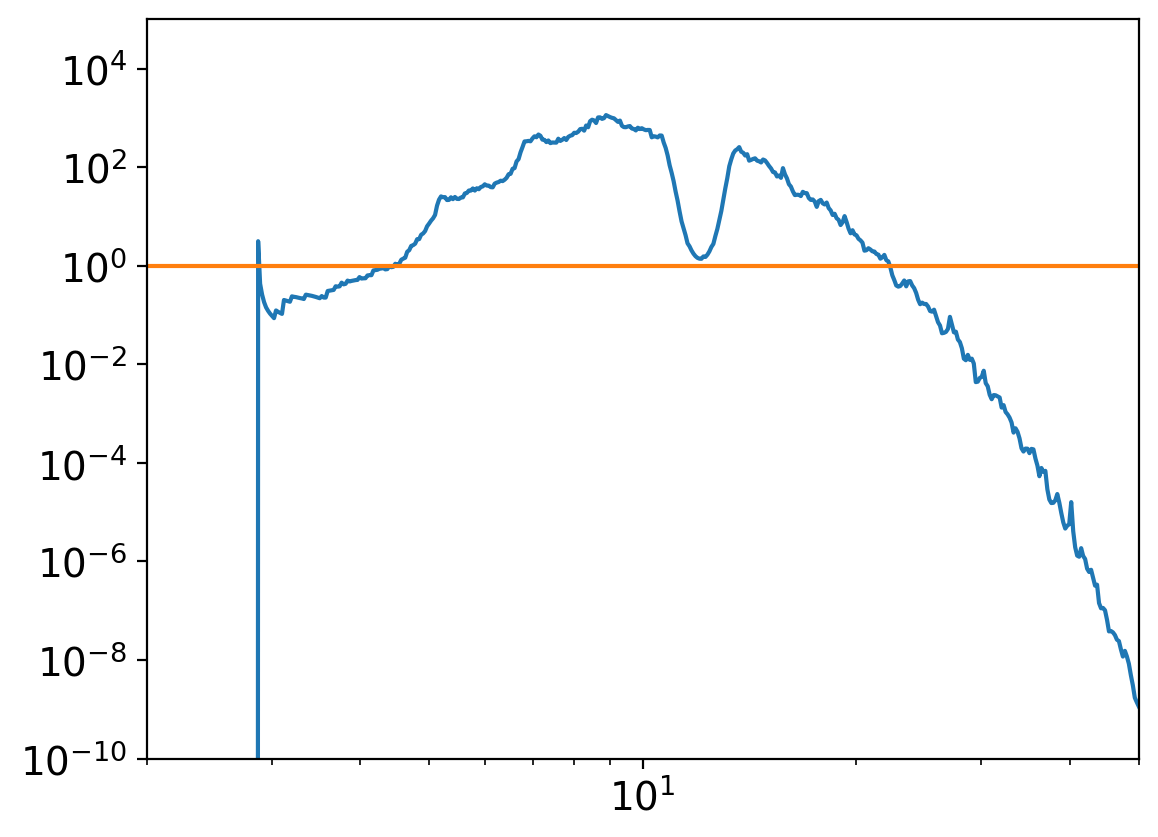

In [78]:
plt.plot(vec_m/keV,arr_poisson_lim[:,0,250])
plt.plot(vec_m/keV,np.ones(len(vec_m)))
plt.xscale('log'); plt.yscale('log');
plt.xlim(2,50); plt.ylim(1e-10,1e5)

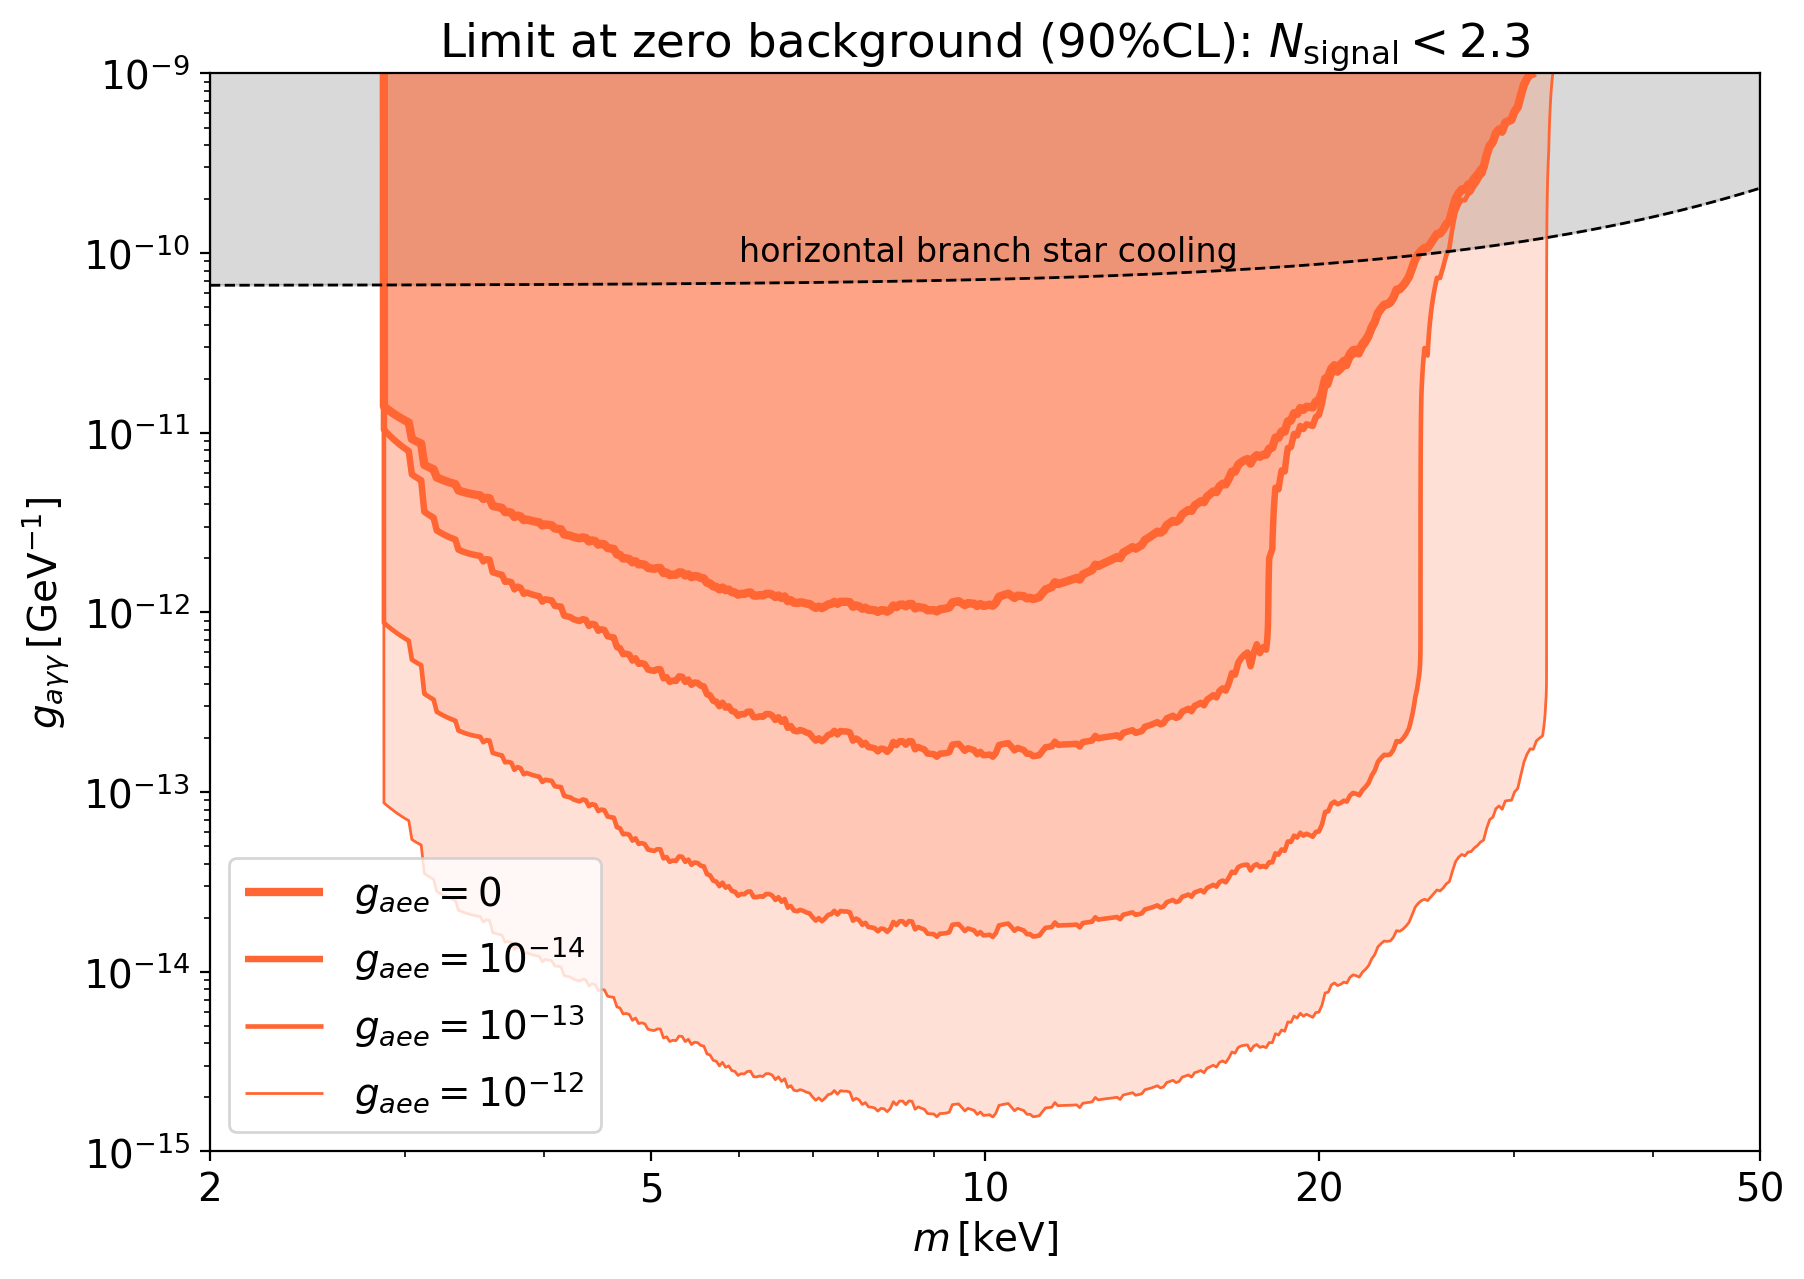

In [79]:
list_lw = np.linspace(3,1,len(vec_gaee))
fig_lim_phot1, ax = plt.subplots(1,1,figsize=(10,7))
#vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(vec_gaee):
    ax.contour(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_N_signal[:,i_e,:])),levels=[np.log10(poisson_limit(0))],
               colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(vec_gaee):
    ax.contourf(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_N_signal[:,i_e,:])),levels=[np.log10(poisson_limit(0)),+30],colors=[(1.,0.4,0.2,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(vec_m):
#    ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(vec_gagg[0],vec_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); 
ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

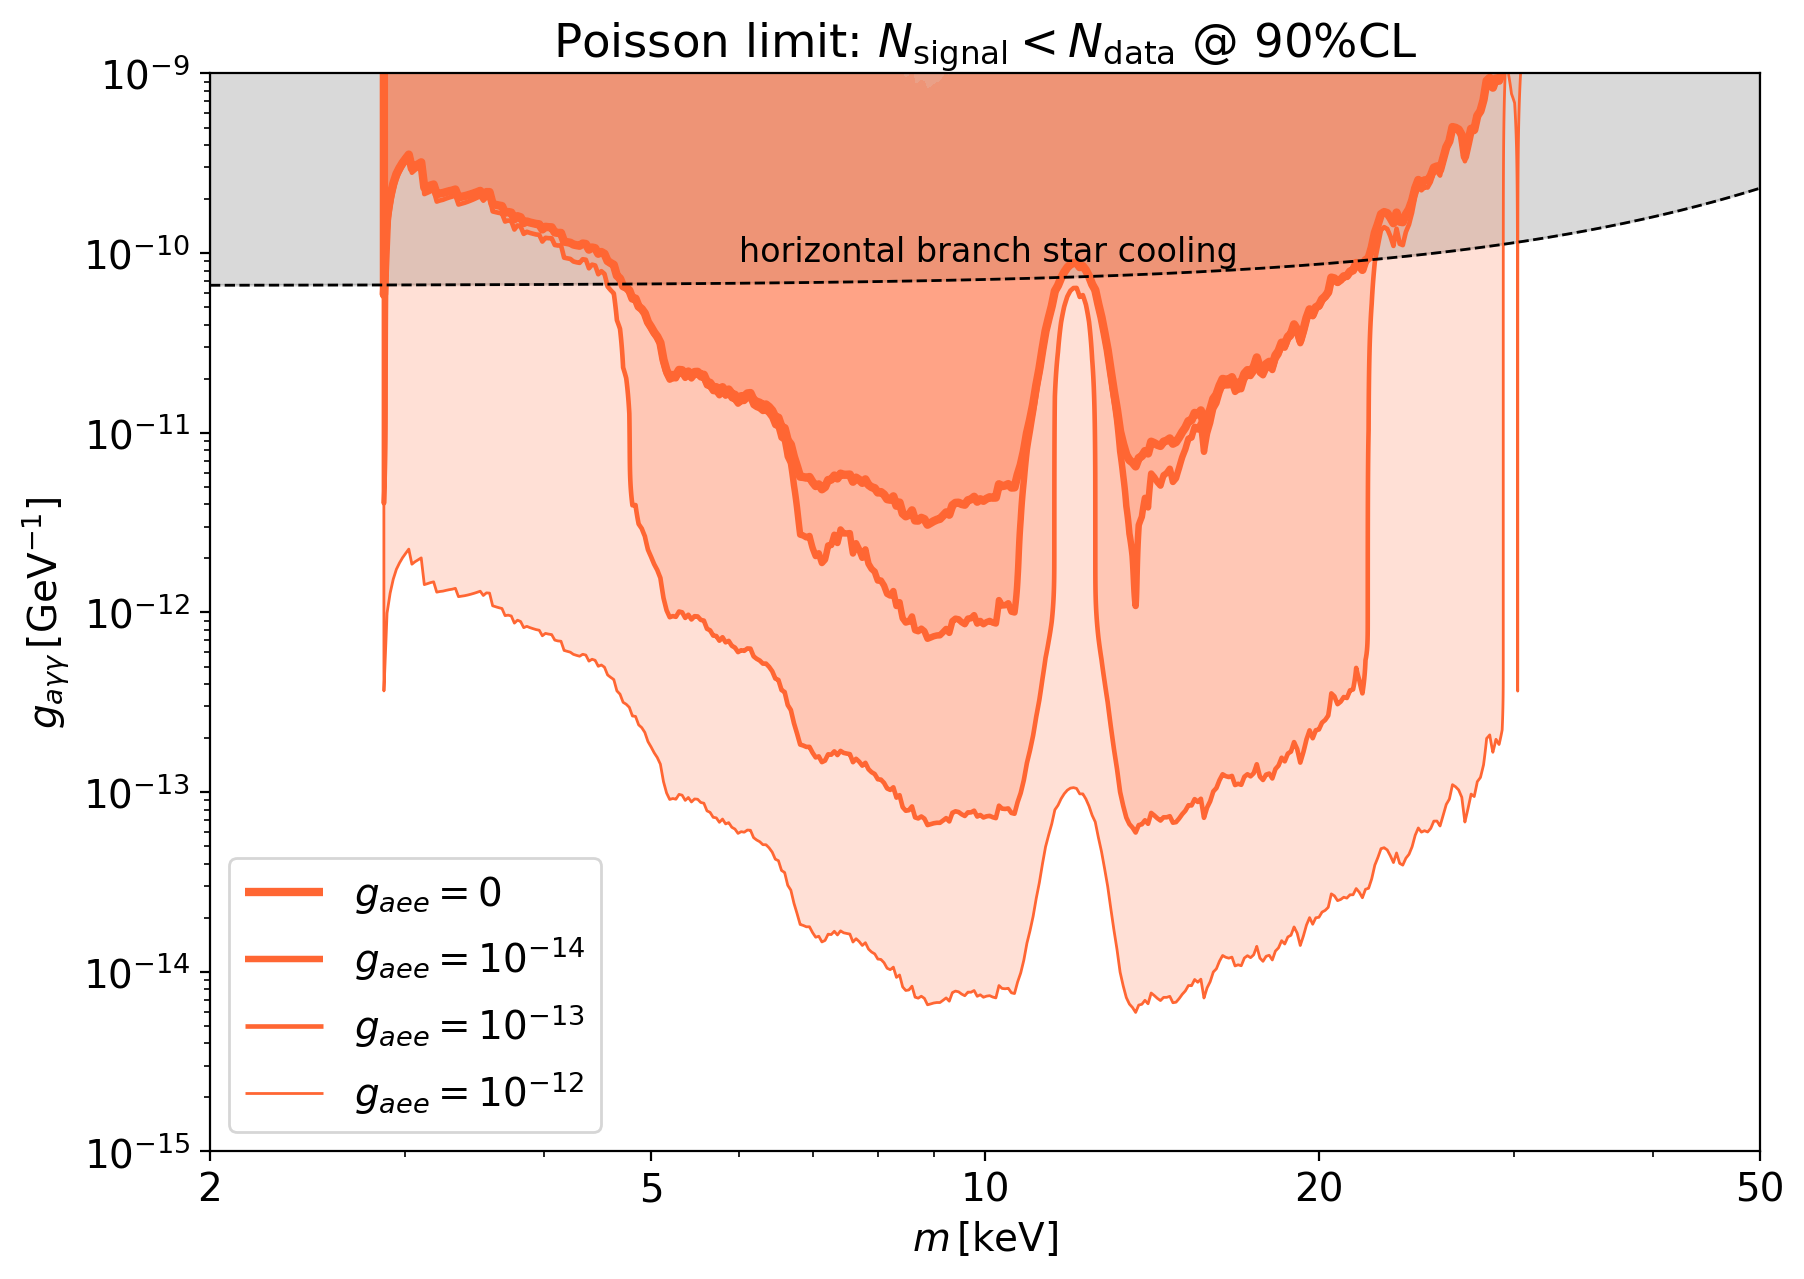

In [80]:
list_lw = np.linspace(3,1,len(vec_gaee))
fig_lim_phot2, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(vec_gaee):
    ax.contour(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(vec_gaee):
    ax.contourf(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0,+5],colors=[(1.,0.4,0.2,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(vec_m):
#    ax.contour(list_gaee,vec_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(vec_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(vec_gagg[0],vec_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

### Pure Electron Coupling Limit

In [63]:
vec_m = keV * np.logspace(np.log10(2),np.log10(50),np.int(5e2))
vec_gaee = np.logspace(-16,-10,np.int(2e2))
vec_gagg = GeV**-1 * np.asarray([0,1e-14,1e-13,1e-12,1e-11,1e-10])
arr_N_signal = np.zeros((len(vec_m),len(vec_gaee),len(vec_gagg)))
for i_m, m in enumerate(tqdm(vec_m)):
    integral = integral_signal(m)
    for i_e, gaee in enumerate(vec_gaee):
        for i_g, gagg in enumerate(vec_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg,precompute=True,integral=integral)+1e-100

100%|██████████| 500/500 [00:29<00:00, 16.99it/s]


In [64]:
arr_N_data = np.zeros(len(vec_m));
arr_N_limit = np.zeros(len(vec_m));
for i_m, m in enumerate(vec_m):
    arr_N_data[i_m] = N_data(m)
    arr_N_limit[i_m] = poisson_limit(N_data(m))
#arr_N_data, arr_N_limit

In [65]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

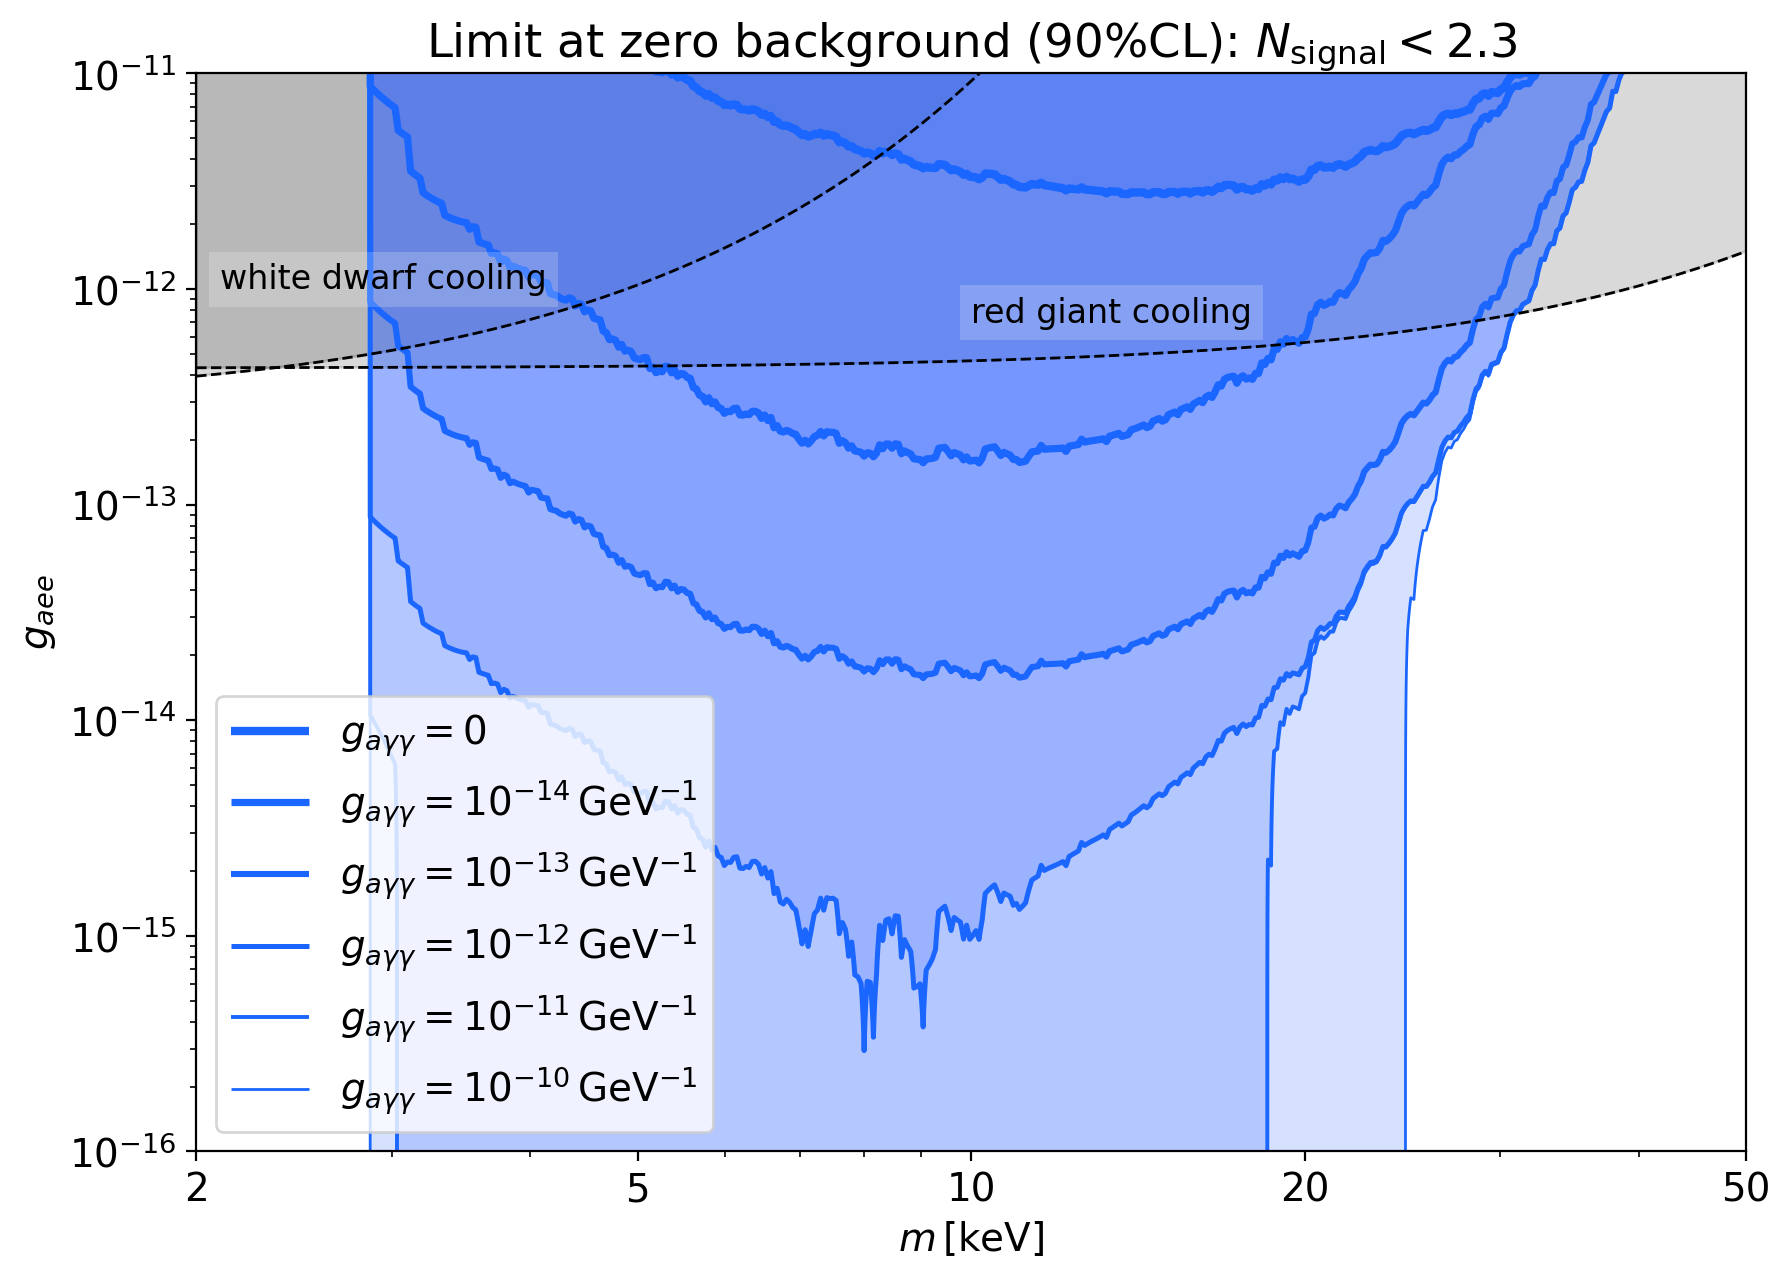

In [66]:
list_lw = np.linspace(3,1,len(vec_gagg))
fig_lim_electron1, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(vec_gagg):
    ax.contour(vec_m/keV,vec_gaee,np.log10(np.transpose(arr_N_signal[:,:,i_g])),levels=[np.log10(poisson_limit(0))],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(vec_gagg):
    ax.contourf(vec_m/keV,vec_gaee,np.log10(np.transpose(arr_N_signal[:,:,i_g])),levels=[np.log10(poisson_limit(0)),+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(vec_m):
#    ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(2.1,1e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

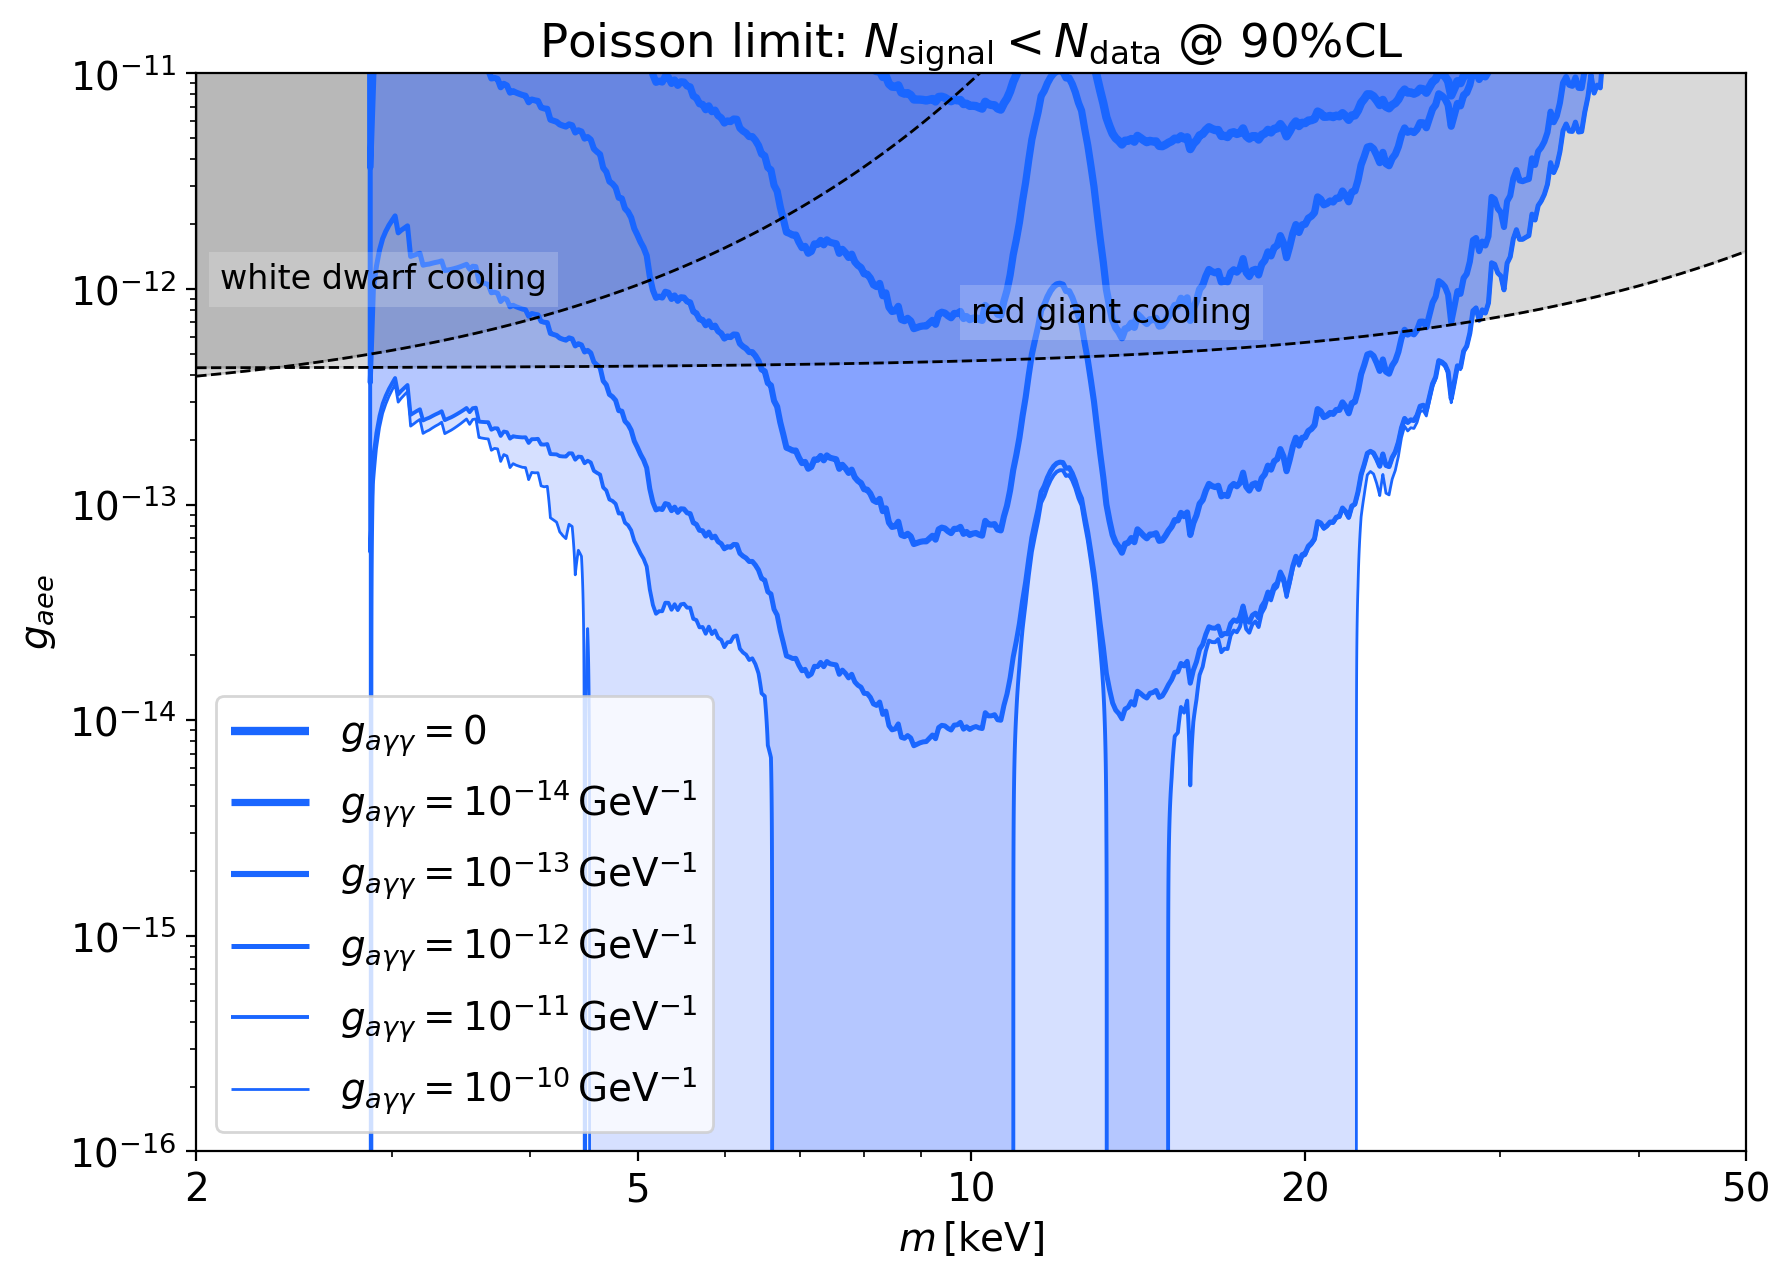

In [67]:
list_lw = np.linspace(3,1,len(vec_gagg))
fig_lim_electron2, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(vec_gagg):
    ax.contour(vec_m/keV,vec_gaee,np.log10(np.transpose(arr_poisson_lim[:,:,i_g])),levels=[0],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(vec_gagg):
    ax.contourf(vec_m/keV,vec_gaee,np.log10(np.transpose(arr_poisson_lim[:,:,i_g])),levels=[0,+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(vec_m):
#    ax.contour(vec_gaee,vec_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(vec_m/keV,vec_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(2.1,1e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));